順位を指標に回帰させる。


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [2]:
data_dir = "F:/TARGET frontier/TXT33/"
data_name = "train"
tail = "fe7"
train_data = pd.read_csv(data_dir+data_name+tail+".csv",encoding="shift-jis",dtype={'レースID(旧)':str})

In [4]:
pd.set_option('display.max_columns', 100)
train_data.head()

,場所,芝・ダ,距離,クラス名,馬場状態,騎手コード,枠番,性別,年齢,キャリア,斤量,間隔,休み明け〜戦目,種牡馬,父タイプ名,調教師コード,前走場所,前芝・ダ,前距離,前クラス名,前走馬場状態,前走騎手コード,前走枠番,前走脚質,前走斤量,前走Ave-3F,前走上り3F,前走PCI3,前走RPCI,前PCI,前好走,前走平均1Fタイム,前走着差タイム,前走単勝オッズ,着差,レースID(旧),複勝オッズ下限,複勝オッズ上限,複勝配当,単勝オッズ,順位,頭数,場所距離芝ダ,場所距離芝ダ.1
0,2,2,1200,2,3,5212,6,2,3,13,56.0,6.0,5.0,572,8,1105,13,2,1400.0,2,2,660.0,2.0,3,54.0,37.2,33.9,59.53,58.2,59.7,0,11.93,0.2,14.6,0.0,0615581112,1.9,2.7,190.0,5.4,1,16,55,37
1,2,2,1200,2,3,5339,6,1,3,10,54.0,3.0,3.0,452,8,1002,1,2,1200.0,7,3,5339.0,7.0,3,54.0,34.5,34.6,48.80,46.9,49.7,0,11.52,0.0,2.2,0.0,0615581111,1.3,1.6,130.0,2.8,2,16,55,12
2,2,2,1200,2,3,5203,3,2,3,9,56.0,5.0,2.0,607,5,1089,3,2,1200.0,2,3,1018.0,8.0,2,56.0,34.5,34.4,50.13,48.0,50.3,0,11.48,0.4,28.6,0.2,0615581106,1.8,2.5,180.0,6.2,3,16,55,170
3,2,2,1200,2,3,1150,4,1,5,17,55.0,2.0,4.0,91,1,1134,2,2,1200.0,2,2,1150.0,6.0,2,53.0,34.1,34.4,48.17,46.3,49.1,0,11.42,0.0,19.1,0.3,0615581108,1.7,2.5,0.0,6.6,4,16,55,101
4,2,2,1200,2,3,1004,8,1,3,15,54.0,2.0,4.0,325,4,1030,2,2,1200.0,2,2,1134.0,2.0,5,53.0,33.6,36.4,48.17,46.3,42.3,1,11.67,1.5,8.6,0.3,0615581116,6.3,9.7,0.0,33.9,5,16,55,101


In [5]:
#test_data
test_data = pd.read_csv(data_dir+"predict"+tail+".csv",encoding="shift-jis",dtype={'レースID(旧)':str})
test_x = test_data.drop(["着差","レースID(旧)","複勝オッズ下限","複勝オッズ上限","複勝配当","順位"],axis=1)
test_y = test_data["順位"]

In [6]:
train_x = train_data.drop(["着差","レースID(旧)","複勝オッズ下限","複勝オッズ上限","複勝配当","順位"],axis=1)
train_y = train_data["順位"]

In [7]:
#チューニング済みパラメータ(etaのみ手動)
params = {'colsample_bytree': 0.65, 
          'gamma': 0.013439667332810353, 
          'max_depth': 5, 
          'min_child_weight': 2.663317188920419, 
          'subsample': 0.9, 
          'booster': 'gbtree', 
          'objective': 'reg:squarederror', 
          'eta': 0.01, 
          'alpha': 0.0, 
          'lambda': 1.0, 
          'random_state': 71}

In [8]:
#これがないとエラー履くので注意
train_y.fillna(10,inplace=True) #無ければ10位に
test_y.fillna(10,inplace=True)

In [9]:
scores = []
histories = []
models = []
kf = KFold(n_splits=4,shuffle=False)
for tr_idx,va_idx in kf.split(train_x):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    dtrain = xgb.DMatrix(tr_x,label=tr_y)
    dvalid = xgb.DMatrix(va_x,label=va_y)
    watchlist = [(dtrain,"train"),(dvalid,"eval")]
    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=10000,
        early_stopping_rounds=100,
        evals=watchlist,
        evals_result=evals_result,
        verbose_eval=500
    )
    models.append(model)
    histories.append(evals_result)
    va_pred = model.predict(dvalid)
    va_y.fillna(0.5,inplace=True) #ここまでok
    #print(va_pred[:10])
    #print(va_y[:10])
    score = mean_squared_error(va_y,va_pred)
    score = np.sqrt(mean_squared_error(va_y,va_pred)) #rmse
    scores.append(score)

print(*scores)
print(np.mean(scores))

[0]	train-rmse:8.5436	eval-rmse:8.61909
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:3.46575	eval-rmse:3.53221
[1000]	train-rmse:3.42281	eval-rmse:3.5132
[1500]	train-rmse:3.39637	eval-rmse:3.50879
[2000]	train-rmse:3.37381	eval-rmse:3.50759
[2500]	train-rmse:3.35273	eval-rmse:3.50677
Stopping. Best iteration:
[2521]	train-rmse:3.35188	eval-rmse:3.5067

[0]	train-rmse:8.54083	eval-rmse:8.62602
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:3.46361	eval-rmse:3.53502
[1000]	train-rmse:3.42203	eval-rmse:3.51792
[1500]	train-rmse:3.3956	eval-rmse:3.5122
[2000]	train-rmse:3.372	eval-rmse:3.50906
[2500]	train-rmse:3.35058	eval-rmse:3.50718
[3000]	train-rmse:3.33009	eval-rmse:3.5058
[3500]	train-rmse:3.31107	eval-rmse:3.505
[4000]	train-rmse:3.29208	eval-rmse:3.50464

In [11]:
#学習結果のプロット
%matplotlib inline
def plot_loss(evals_result, title):
    train_metric = evals_result['train']['rmse']
    plt.plot(train_metric, label='train rmse')
    eval_metric = evals_result['eval']['rmse']
    plt.plot(eval_metric, label='eval rmse')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.xlabel('rounds')
    plt.ylabel('rmse')
    plt.show()

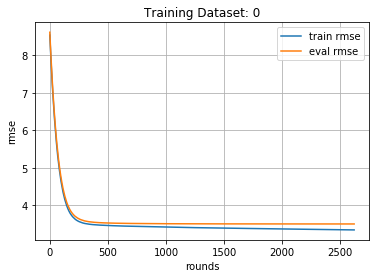

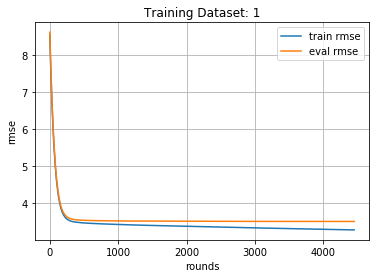

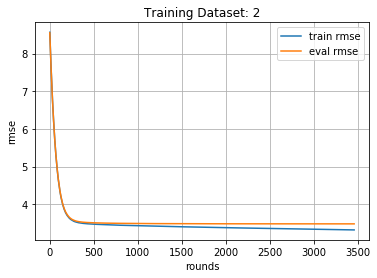

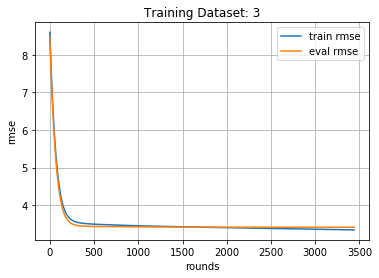

In [12]:
for i in range(4):
    plot_loss(histories[i],f'Training Dataset: {i}')

In [13]:
test_length = len(test_data)
predict = np.array([0.0]*test_length)
dtest = xgb.DMatrix(test_x,label=test_y) #本来は学習に使用していないデータにする
for i in range(4):
    y_pred_proba = models[i].predict(dtest)
    predict += y_pred_proba

predict /= 4

In [18]:
y = pd.DataFrame(predict,columns=["y'"])
output = test_data #ここも書き換えること

output = pd.concat([output,y],axis=1)

output["複勝配当"] = output["複勝配当"].astype("int64")
output.to_csv("C:/programs/HRP/neweval4.csv",index=False,encoding="shift-jis")

In [15]:
fscore = model.get_score(importance_type="total_gain")
fscore = sorted([(k,v) for k,v in fscore.items()] ,key=lambda tpl: tpl[1], reverse = True)
print(*fscore[:20])

('単勝オッズ', 33625198.84694131) ('頭数', 4884162.663115621) ('前走単勝オッズ', 3971601.806920225) ('前走着差タイム', 1671724.0808191206) ('前好走', 1360848.5434570403) ('間隔', 820480.3537933639) ('前走Ave-3F', 568300.2932567237) ('前PCI', 450946.7091337878) ('騎手コード', 450545.8458690553) ('前走脚質', 448625.8918269801) ('前走平均1Fタイム', 448078.8476243465) ('前走PCI3', 443110.9660966608) ('前距離', 442730.7420753297) ('休み明け〜戦目', 417648.8073510373) ('前走上り3F', 411326.84237903607) ('種牡馬', 405492.84820740944) ('クラス名', 385450.3439564563) ('キャリア', 372780.5077319239) ('調教師コード', 346102.07827667636) ('前走騎手コード', 316182.0840835011)


In [16]:
#全体を100[%]とした時の重要度
mother = sum([j for i,j in fscore])
for i,j in fscore[:25]:
    print(i,round((j/mother)*100,1))

単勝オッズ 60.9
頭数 8.8
前走単勝オッズ 7.2
前走着差タイム 3.0
前好走 2.5
間隔 1.5
前走Ave-3F 1.0
前PCI 0.8
騎手コード 0.8
前走脚質 0.8
前走平均1Fタイム 0.8
前走PCI3 0.8
前距離 0.8
休み明け〜戦目 0.8
前走上り3F 0.7
種牡馬 0.7
クラス名 0.7
キャリア 0.7
調教師コード 0.6
前走騎手コード 0.6
前クラス名 0.6
前走RPCI 0.6
距離 0.5
場所距離芝ダ 0.4
芝・ダ 0.4


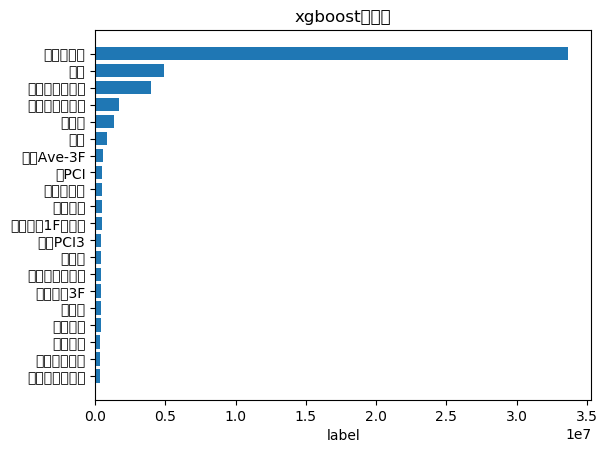

In [17]:
slen = 20
label = []
weight = []
for i,j in fscore[:slen]:
    label.append(i)
    weight.append(j)

plt.rcdefaults() #横棒グラフモード
fig, ax = plt.subplots()
y_pos = np.arange(slen)
ax.barh(y_pos, weight,align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(label)
ax.invert_yaxis()
ax.set_xlabel('label')
ax.set_title('xgboost特徴量')
plt.show()
    

In [20]:
#save models
import pickle
with open('xgmachina_ver0.0.6.pickle', mode='wb') as fp:
    pickle.dump(models, fp)

In [ ]:
#import models
"""import pickle
with open('xgmachina_ver0.0.6.pickle', mode='rb') as fp:
    models = pickle.load(fp)"""